#0  Insurance Fraud Detection

## Problem Statement
Detect fraudulent insurance claims using claim details, customer demographics, and historical claim patterns to reduce financial loss and automate fraud detection.

### ML Goals:
- **Classification**: Fraud vs. Non-Fraud claims.
- **Imbalance Handling**: Address class imbalance with SMOTE or weighting.
- **Feature Analysis**: Identify factors most indicative of fraud.


##1 Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE

##2 Load and Merge Data

In [2]:
# Load datasets
insurance_df = pd.read_csv('insurance_data.csv')
vendor_df = pd.read_csv('vendor_data.csv')
insurance_df = insurance_df.merge(vendor_df, on='VENDOR_ID', how='left')
insurance_df.head()

,TXN_DATE_TIME,TRANSACTION_ID,CUSTOMER_ID,POLICY_NUMBER,POLICY_EFF_DT,LOSS_DT,REPORT_DT,INSURANCE_TYPE,PREMIUM_AMOUNT,CLAIM_AMOUNT,...,INCIDENT_CITY,INCIDENT_HOUR_OF_THE_DAY,AGENT_ID,VENDOR_ID,VENDOR_NAME,ADDRESS_LINE1_y,ADDRESS_LINE2_y,CITY_y,STATE_y,POSTAL_CODE_y
0,2020-06-01 00:00:00,TXN00000001,A00003822,PLC00008468,2015-06-23,2020-05-16,2020-05-21,Health,157.13,9000,...,Savannah,4,AGENT00413,VNDR00556,Ramsey Inc,3114 West 20th Court,NaN,Panama City,FL,32405.0
1,2020-06-01 00:00:00,TXN00000002,A00008149,PLC00009594,2018-04-21,2020-05-13,2020-05-18,Property,141.71,26000,...,Montgomery,0,AGENT00769,VNDR00592,"Morales, Campbell and Washington",42 West Louise Street,B,Fayetteville,AR,72701.0
2,2020-06-01 00:00:00,TXN00000003,A00003172,PLC00007969,2019-10-03,2020-05-21,2020-05-26,Property,157.24,13000,...,Grand Junction,19,AGENT00883,VNDR00031,Johnson Ltd,2619 North Quality Lane,#315,Fayetteville,AR,72703.0
3,2020-06-01 00:00:00,TXN00000004,A00007572,PLC00009292,2016-11-29,2020-05-14,2020-05-19,Health,172.87,16000,...,Savannah,12,AGENT00278,VNDR00075,Blackwell-Foster,3609 Meadow Drive,NaN,Nashville,TN,37215.0
4,2020-06-01 00:00:00,TXN00000005,A00008173,PLC00000204,2011-12-26,2020-05-17,2020-05-22,Travel,88.53,3000,...,Nashville,18,AGENT00636,VNDR00472,Evans-Scott,4001 19th Place Northeast,NaN,Washington,DC,20018.0


##3 Exploratory Data Analysis
- Check data types and missing values
- Analyze numeric and categorical features
- Check class imbalance


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   TXN_DATE_TIME             10000 non-null  object 
 1   TRANSACTION_ID            10000 non-null  object 
 2   CUSTOMER_ID               10000 non-null  object 
 3   POLICY_NUMBER             10000 non-null  object 
 4   POLICY_EFF_DT             10000 non-null  object 
 5   LOSS_DT                   10000 non-null  object 
 6   REPORT_DT                 10000 non-null  object 
 7   INSURANCE_TYPE            10000 non-null  object 
 8   PREMIUM_AMOUNT            10000 non-null  float64
 9   CLAIM_AMOUNT              10000 non-null  int64  
 10  CUSTOMER_NAME             10000 non-null  object 
 11  ADDRESS_LINE1_x           10000 non-null  object 
 12  ADDRESS_LINE2_x           1495 non-null   object 
 13  CITY_x                    9946 non-null   object 
 14  STATE_x

/tmp/ipython-input-3788474785.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='CLAIM_STATUS', data=insurance_df, palette={'A': 'green', 'D': 'red'})


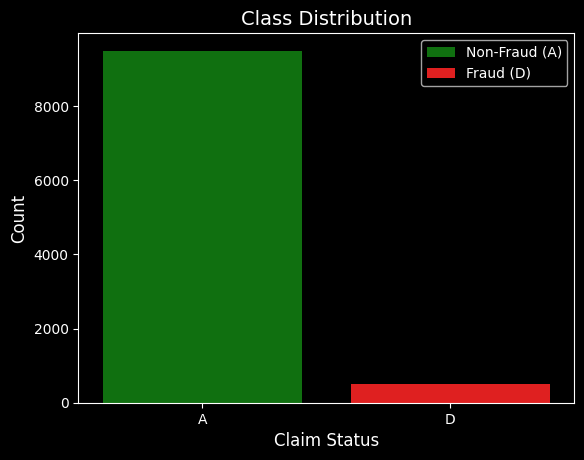

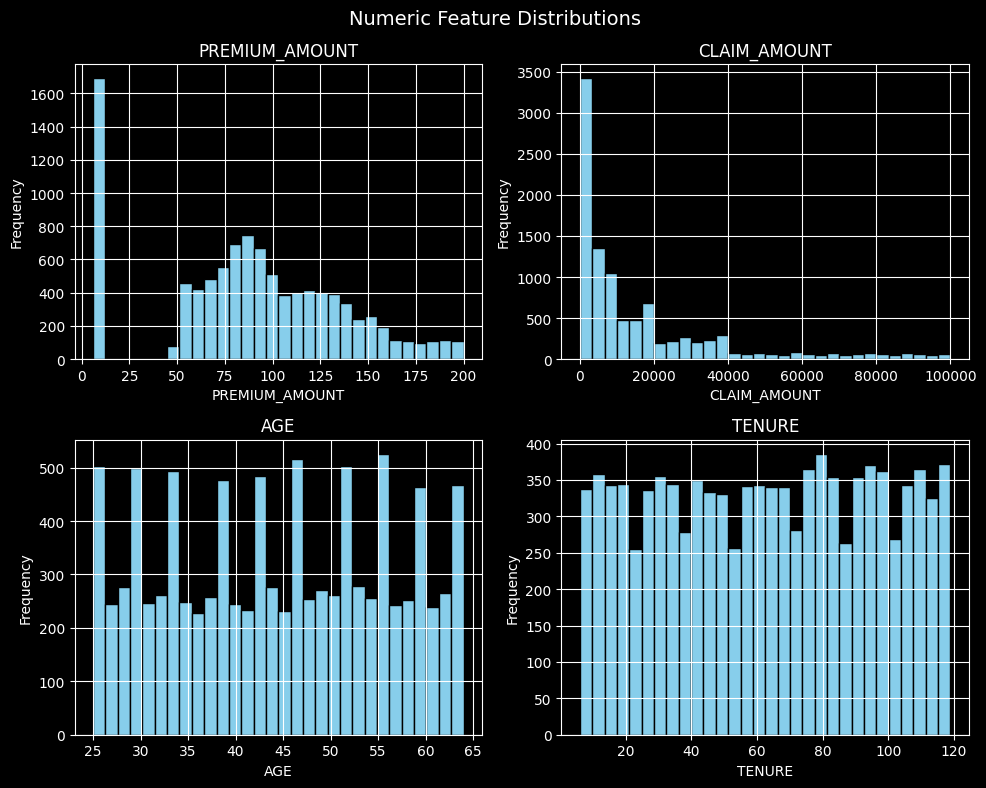

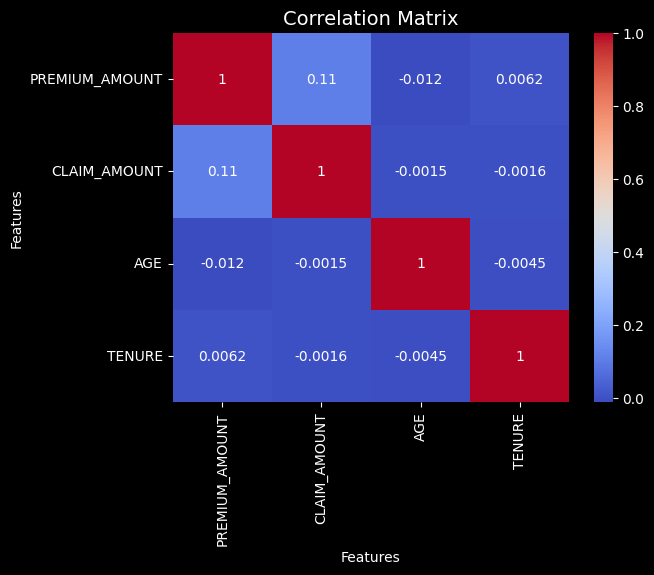

In [4]:

# Basic info
print(insurance_df.info())
print(insurance_df.isnull().sum())

# Target distribution with colors and legend
plt.style.use('dark_background')
sns.countplot(x='CLAIM_STATUS', data=insurance_df, palette={'A': 'green', 'D': 'red'})
plt.title('Class Distribution', fontsize=14)
plt.xlabel('Claim Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(['Non-Fraud (A)', 'Fraud (D)'], loc='upper right')
plt.show()

# Numeric feature distributions with axis labels and legend
numeric_cols = ['PREMIUM_AMOUNT', 'CLAIM_AMOUNT', 'AGE', 'TENURE']
axes = insurance_df[numeric_cols].hist(bins=30, figsize=(10,8), color='skyblue', edgecolor='black')
plt.suptitle('Numeric Feature Distributions', fontsize=14)
for ax, col in zip(axes.flatten(), numeric_cols):
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

# Correlation matrix with axis labels
corr = insurance_df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix', fontsize=14)
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()


##3 Data Cleaning and Missing Value Handling

In [5]:

# Drop unnecessary columns if they exist
cols_to_drop = ['TXN_DATE_TIME','TRANSACTION_ID','CUSTOMER_NAME','ADDRESS_LINE1','ADDRESS_LINE2',
                'CITY','STATE','POSTAL_CODE','SSN','ROUTING_NUMBER','ACCT_NUMBER']
insurance_df.drop(columns=[col for col in cols_to_drop if col in insurance_df.columns], inplace=True)

# Fill missing categorical values
for col in ['MARITAL_STATUS','CUSTOMER_EDUCATION_LEVEL','VENDOR_NAME']:
    if col in insurance_df.columns:
        insurance_df[col].fillna('Unknown', inplace=True)


/tmp/ipython-input-1018327052.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  insurance_df[col].fillna('Unknown', inplace=True)


##4 Feature Engineering

In [9]:

categorical_cols = ['INSURANCE_TYPE','MARITAL_STATUS','EMPLOYMENT_STATUS','HOUSE_TYPE','SOCIAL_CLASS',
                    'CUSTOMER_EDUCATION_LEVEL','INCIDENT_SEVERITY','AUTHORITY_CONTACTED','ANY_INJURY',
                    'POLICE_REPORT_AVAILABLE','INCIDENT_STATE','INCIDENT_CITY','VENDOR_NAME']
numeric_cols = ['PREMIUM_AMOUNT','CLAIM_AMOUNT','AGE','TENURE','NO_OF_FAMILY_MEMBERS']

X = insurance_df[categorical_cols + numeric_cols]
y = insurance_df['CLAIM_STATUS'].apply(lambda x: 1 if x=='D' else 0)

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_cols),
                                               ('cat', categorical_transformer, categorical_cols)])


##5 Train/Test Split and SMOTE

Split Data and Handle Imbalance

In [10]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_transformed, y_train)


##6 Train Models

In [13]:

# Logistic Regression
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train_res, y_train_res)

# RandomForest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_res, y_train_res)

# Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_res.toarray(), y_train_res)  # Convert sparse to dense for GB


GradientBoostingClassifier(random_state=42)

##7 Evaluate Models

In [14]:

print("Logistic Regression Report:")
print(classification_report(y_test, log_reg_model.predict(X_test_transformed)))

print("\nRandomForest Report:")
print(classification_report(y_test, rf_model.predict(X_test_transformed)))

print("\nGradientBoosting Report:")
print(classification_report(y_test, gb_model.predict(X_test_transformed.toarray())))


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.95      0.71      0.82      1899
           1       0.06      0.37      0.11       101

    accuracy                           0.69      2000
   macro avg       0.51      0.54      0.46      2000
weighted avg       0.91      0.69      0.78      2000


RandomForest Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1899
           1       0.00      0.00      0.00       101

    accuracy                           0.95      2000
   macro avg       0.47      0.50      0.49      2000
weighted avg       0.90      0.95      0.92      2000


GradientBoosting Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1899
           1       0.00      0.00      0.00       101

    accuracy                           0.95      2000
   macro avg       0.47      0.50      0.49      200

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

##8 ROC Curve Comparison

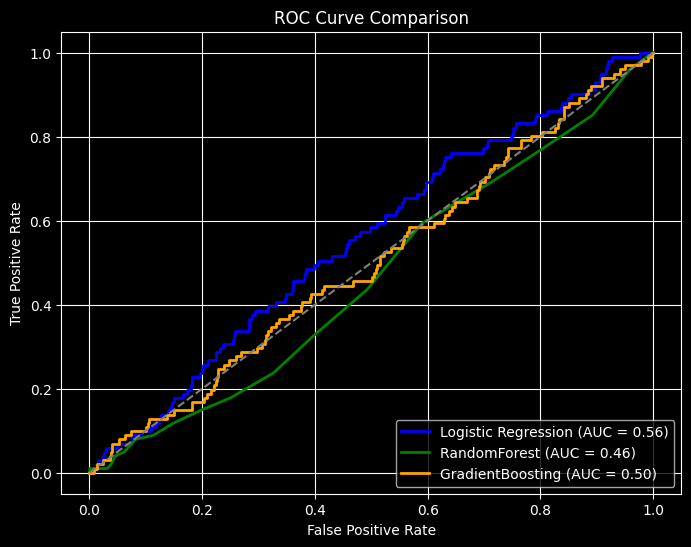

In [15]:

# Probabilities
y_prob_log = log_reg_model.predict_proba(X_test_transformed)[:,1]
y_prob_rf = rf_model.predict_proba(X_test_transformed)[:,1]
y_prob_gb = gb_model.predict_proba(X_test_transformed.toarray())[:,1]

# ROC metrics
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)

roc_auc_log = auc(fpr_log, tpr_log)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_gb = auc(fpr_gb, tpr_gb)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_log:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'RandomForest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_gb, tpr_gb, color='orange', lw=2, label=f'GradientBoosting (AUC = {roc_auc_gb:.2f})')
plt.plot([0,1],[0,1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()





# 📌 Final Model Performance Summary

## ✅ 1. Class Imbalance
- The dataset is **highly imbalanced**:
  - **Non-Fraud (A)** ≈ 9,000+ claims
  - **Fraud (D)** ≈ 500 claims
- This imbalance significantly impacts model performance, especially recall for fraud detection.

---

## ✅ 2. Logistic Regression
- **Accuracy:** 69%
- **Fraud Detection (Class 1):**
  - Precision: **0.06** (very low)
  - Recall: **0.37** (better than other models)
  - F1-score: **0.11**
- **ROC-AUC:** **0.56**
- **Interpretation:**  
  Logistic Regression detects some fraud cases (recall = 37%) but misclassifies many, leading to poor precision.

---

## ✅ 3. RandomForest
- **Accuracy:** 95%
- **Fraud Detection (Class 1):**
  - Precision: **0.00**
  - Recall: **0.00**
  - F1-score: **0.00**
- **ROC-AUC:** **0.46**
- **Interpretation:**  
  RandomForest predicts almost all claims as non-fraud due to imbalance. High accuracy is misleading because it ignores minority class.

---

## ✅ 4. Gradient Boosting
- **Accuracy:** 95%
- **Fraud Detection (Class 1):**
  - Precision: **0.00**
  - Recall: **0.00**
  - F1-score: **0.00**
- **ROC-AUC:** **0.50**
- **Interpretation:**  
  Similar to RandomForest, Gradient Boosting fails to identify fraud cases.

---

## ✅ 5. ROC Curve Insights
- All models perform poorly on fraud detection:
  - Logistic Regression (Blue): **Best among three**, but still weak (AUC = 0.56).
  - RandomForest (Green): AUC = 0.46.
  - GradientBoosting (Orange): AUC = 0.50.
- **None of the models show strong discriminatory power**.

---

## ✅ Key Takeaways
- **Severe class imbalance** is the root cause of poor fraud detection.
- Accuracy is misleading; focus on **recall and AUC** for fraud class.
- Logistic Regression slightly outperforms tree-based models in this scenario.

---

## ✅ Recommendations
1. **Improve imbalance handling**:
   - Use **SMOTE**, **ADASYN**, or **class weights** more aggressively.
   - Consider **undersampling majority class**.
2. **Feature Engineering**:
   - Create interaction features (e.g., claim amount vs premium ratio).
   - Include temporal patterns (e.g., claim frequency).
3. **Modeling**:
   - Try **XGBoost or LightGBM** with tuned hyperparameters.
   - Use **ensemble methods** or **cost-sensitive learning**.
4. **Evaluation**:
   - Use **Precision-Recall curves** and **F1-score for fraud class** as primary metrics.

---

### ✅ Next Steps
- Implement **advanced resampling techniques**.
- Add **hyperparameter tuning for GradientBoosting and XGBoost**.
- Explore **cost-sensitive learning** to penalize misclassification of fraud cases.
